# Transformaciones espaciales

Las categorías principales de procesamiento espacial son las transformaciones de intensidad y los filtros espaciales, pueden ser denotados con la expresión:
$$
g(x,y) = T[f(x,y)]
$$
donde $f(x,y)$ es la imagen de entrada, $g(x,y)$ es la imagen de salida. y $T$ es un operador en $f$ definido sobre un vecindario del punto $(x,y)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from pydicom import dcmread

In [2]:
img = dcmread('data/sample/1/d9a40467af6c649351914bd8c6fe71c4.dicom').pixel_array

In [3]:
def dcm_show_transform(array, titles=None):
    if titles is None:
        titles = ['Transform']

    array.insert(0, img)
    titles.insert(0, 'Original Image')
        
    plt.figure(figsize=(10, 10))
    
    for i in range(len(titles)):
        plt.subplot(1, len(titles), i + 1)
        plt.title(titles[i])
        plt.axis('off')
        plt.imshow(array[i], cmap=plt.gray())

## Negativo

$$
    s = L-1-r,\quad r\in [0, L-1]
$$

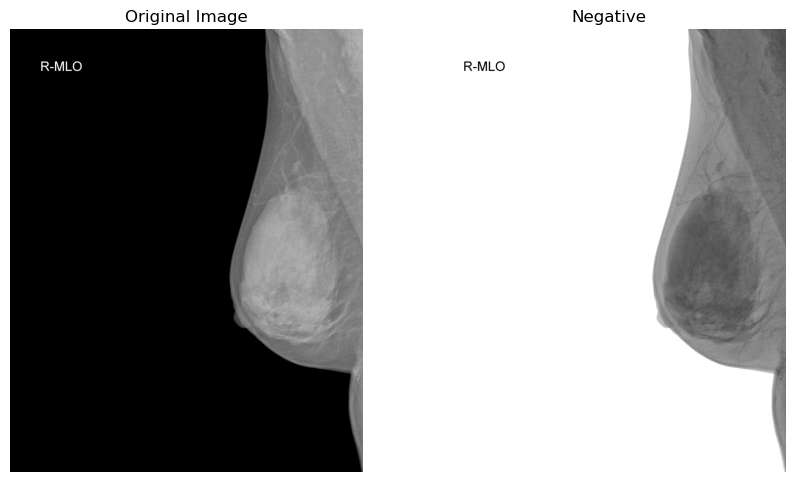

In [4]:
inv = cv.bitwise_not(img)
dcm_show_transform([inv], ['Negative'])

## Transformación log

$$
    s = c \log(1+r), \quad c = \frac{f_{max}-f_{min}}{\log (f_{max}-f_{min})}
$$

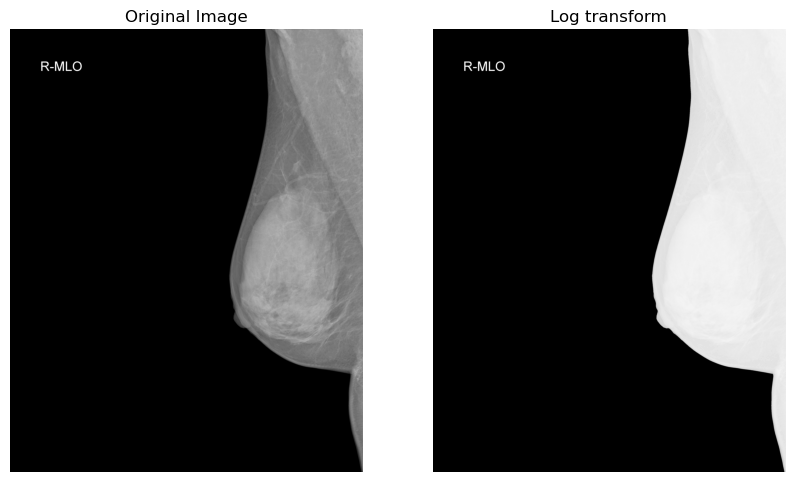

In [5]:
delta = np.ptp(img)
c = delta / np.log(delta)
log = c * np.log(1 + img)

dcm_show_transform([log], ['Log transform'])

## Transformación gamma

$$
    s = cr^\gamma
$$

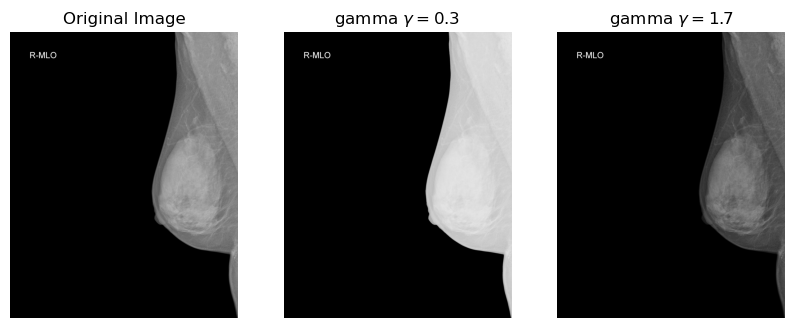

In [6]:
# from matplotlib.widgets import Button, Slider
gamma = 0.7

pwr = np.power(img / delta, (1 - gamma)) * delta 
sqrt = np.power(img / delta, (1 + gamma)) * delta
dcm_show_transform([pwr, sqrt], 
                   [r'gamma $\gamma=' + str(round(1 - gamma, 2)) + '$', 
                    r'gamma $\gamma=' + str(round(1 + gamma, 2)) + '$'])

## Contrast stretching

$$
    s = \frac{r - f_{min}}{f_{max} - f_{min}}
$$

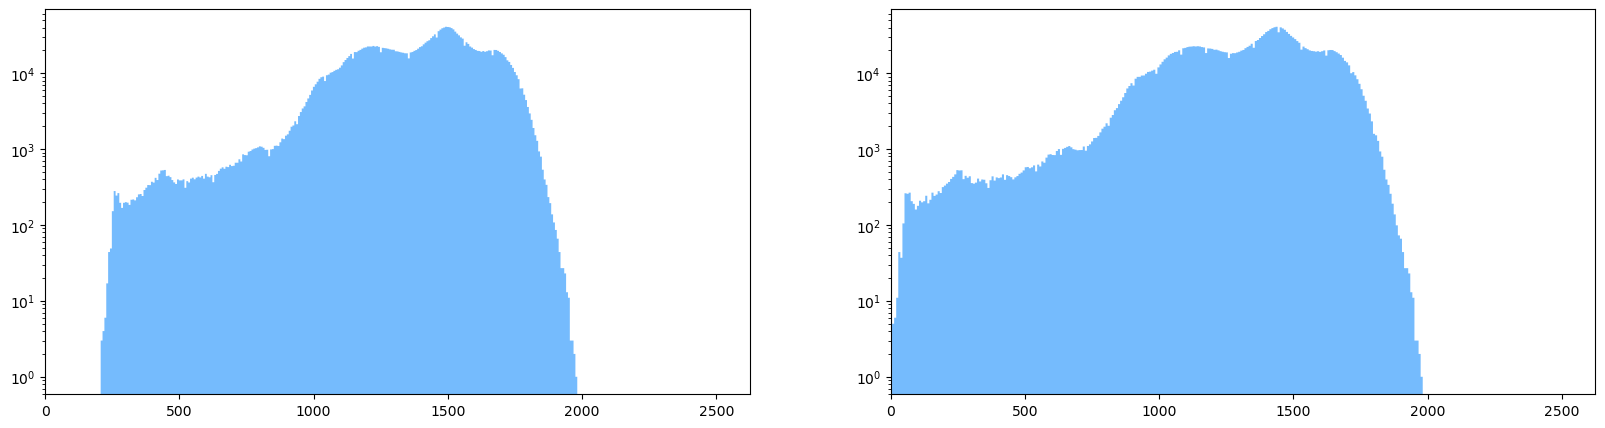

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Imagen
stretch = np.where(img > np.max(img) - 1, 0, img)

ax[0].hist(stretch[stretch > 0].ravel(), bins=256, histtype='stepfilled', color='xkcd:sky blue')
ax[0].set_xlim([0, np.max(img)])
ax[0].set_yscale('log')

# Transformada
stretch_transform = ((stretch[stretch > 0] - np.min(stretch[stretch > 0])) / np.ptp(stretch[stretch > 0])) * np.max(stretch)

ax[1].hist(stretch_transform[stretch_transform > 0].ravel(), bins=256, histtype='stepfilled', color='xkcd:sky blue')
ax[1].set_xlim([0, np.max(img)])
ax[1].set_yscale('log')
plt.show()

In [8]:
# dcm_show_transform([stretch_transform], ['Stretch transform'])